In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import ibm_db
import ibm_db_dbi

In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa
!pip install ipython-sql

In [3]:
%load_ext sql

In [5]:
%sql ibm_db_sa://blg11630:jsnv%2Bw47652s064m@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB

In [6]:
dsn_hostname = "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_uid = "blg11630"  
dsn_pwd = "jsnv+w47652s064m" 

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"          
dsn_port = "50000"                
dsn_protocol = "TCPIP"

In [7]:
#Create the dsn connection string
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

In [8]:
#Create database connection

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  blg11630 on host:  dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net


In [10]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

In [11]:
%sql select TABSCHEMA, TABNAME, CREATE_TIME from SYSCAT.TABLES \
      where TABSCHEMA not in ('SYSIBM', 'SYSCAT', 'SYSSTAT', 'SYSIBMADM', 'SYSTOOLS', 'SYSPUBLIC')

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
BLG11630,CENSUS_DATA,2021-05-31 20:48:27.134126
BLG11630,CHICAGO_PUBLIC_SCHOOLS,2021-05-31 20:50:10.198124
BLG11630,CHICAGO_CRIME_DATA,2021-05-31 20:51:23.002158
BLG11630,US_FOMC_RATES,2021-06-02 14:51:56.612101
BLG11630,US_ISM_MANUFACTURING_PMI,2021-06-02 14:53:46.824188
BLG11630,US_CPI,2021-06-02 14:49:53.314324
BLG11630,US_ISM_SERVICES_PMI,2021-06-02 14:54:59.504757
BLG11630,US_NFP_RATES,2021-06-02 14:55:56.584638
BLG11630,US_TRADE_BALANCE,2021-06-02 14:57:34.241315
BLG11630,US_RETAIL_SALES,2021-06-02 14:58:36.464754


In [93]:
features = ['US_TRADE_BALANCE', 'US_NFP_RATES']
features_dict = {}
for feature in features:
    selectQuery = 'select * from '+ feature #Construct the query that retrieves all rows from the INSTRUCTOR table
    features_dict[feature] = pd.read_sql(selectQuery, pconn) #Execute the statement
    features_dict[feature].columns = ['Date', feature]
    features_dict[feature].dropna(axis=0, inplace=True)

In [94]:
for value in features_dict.values():
    value['Year'] = pd.to_datetime(value['Date']).dt.year.astype('str') 
    value['Month'] = pd.to_datetime(value['Date']).dt.month.astype('str')
    value['Date_time'] = value['Year']+'-'+value['Month']
    value.drop(['Year','Month'], 1, inplace=True)    

In [95]:
features_dict['US_TRADE_BALANCE'].head()

,Date,US_TRADE_BALANCE,Date_time
0,2021-05-04,-74.4,2021-5
1,2021-04-07,-71.1,2021-4
2,2021-03-05,-68.2,2021-3
3,2021-02-05,-66.6,2021-2
4,2021-01-07,-68.1,2021-1


In [96]:
features_dict['US_NFP_RATES'].head()

,Date,US_NFP_RATES,Date_time
0,2021-05-07,0.061,2021-5
1,2021-04-02,0.060,2021-4
2,2021-03-05,0.062,2021-3
3,2021-02-05,0.063,2021-2
4,2021-01-08,0.067,2021-1


In [97]:
features_dict1 = features_dict.copy()
for value in features_dict1.values():
    value.drop('Date', 1, inplace=True)

In [98]:
dataset = pd.concat(features_dict1.values(), axis=1)
dataset = dataset.loc[:,~dataset.columns.duplicated()] #Get rid of duplicate columns
dataset.head()

,US_TRADE_BALANCE,Date_time,US_NFP_RATES
0,-74.4,2021-5,0.061
1,-71.1,2021-4,0.060
2,-68.2,2021-3,0.062
3,-66.6,2021-2,0.063
4,-68.1,2021-1,0.067


In [99]:
label = %sql select * from US_FOMC_RATES
label = pd.DataFrame(label, columns = ['Date','US_FOMC_RATES'])
label.dropna(axis=0, inplace=True)
label['Year'] = pd.to_datetime(label['Date']).dt.year.astype('str') 
label['Month'] = pd.to_datetime(label['Date']).dt.month.astype('str')
label['Date_time'] = label['Year']+'-'+label['Month']
label.drop(['Year','Month'], 1, inplace=True)

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


In [100]:
label1 = label.copy()
label1.drop('Date', 1, inplace=True)
label1.head()

,US_FOMC_RATES,Date_time
0,0.0025,2021-4
1,0.0025,2021-3
2,0.0025,2021-1
3,0.0025,2020-12
4,0.0025,2020-11


In [101]:
dataset = dataset.merge(label1, on='Date_time', how='inner')
dataset.drop('Date_time', 1, inplace=True)        

In [102]:
dataset

,US_TRADE_BALANCE,US_NFP_RATES,US_FOMC_RATES
0,-71.1,0.060,0.0025
1,-68.2,0.062,0.0025
2,-68.1,0.067,0.0025
3,-63.1,0.067,0.0025
4,-63.9,0.069,0.0025
...,...,...,...
86,-42.8,0.096,0.0025
87,-49.9,0.095,0.0025
88,-40.3,0.097,0.0025
89,-39.7,0.097,0.0025


In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [104]:
N = dataset.iloc[:,:-1]
Z = dataset.iloc[:,-1].astype(str)
N_train, N_test, Z_train, Z_test = train_test_split(N, Z, test_size=0.2, random_state=1)

4


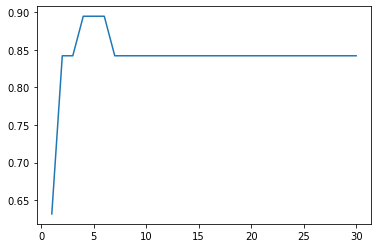

In [105]:
md_scores = {}
for md in range(1,31):  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = md)
    loanTree.fit(N_train, Z_train)
    md_scores[md] = loanTree.score(N_test, Z_test)
opt_md = list(md_scores.keys())[list(md_scores.values()).index(max(md_scores.values()))]
print(opt_md)
sns.lineplot(x = list(md_scores.keys()), y = list(md_scores.values()))

In [106]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = opt_md)
loanTree.fit(N_train,Z_train)
ln_pred = loanTree.predict(N_test)
ln_pred = ln_pred.tolist()

In [107]:
df_2 = pd.DataFrame({'Actual': Z_test, 'Decision-Tree Pred_1':ln_pred})
df_2

,Actual,Decision-Tree Pred_1
58,0.0025,0.0025
88,0.0025,0.0025
43,0.0050,0.0050
55,0.0025,0.0025
73,0.0025,0.0025
86,0.0025,0.0025
60,0.0025,0.0025
52,0.0025,0.0025
46,0.0025,0.0025
39,0.0050,0.0050


In [108]:
ibm_db.close(conn)

True